In [1]:
from sklearn.cluster import SpectralClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

from functions import *

Determine the true transition probability matrix $A$ to construct the underlying regime sequence

In [2]:

N = 5 # number of assets in portfolio
M = 3 # number of regimes (states)
T = 500 # amount of timestamps
T_test = 200 # n of timestamps used for evaluating/testing the model

# define A (transition prob. matrix)
A_real = np.array([
    [0.95, 0.05, 0.00],
    [0.06, 0.91, 0.03],
    [0.00, 0.12, 0.88]
])

n_regime_transitions = 0

init_regime_prob_dist = [0.7, 0.15, 0.15]

regime = np.random.choice(range(M), p=init_regime_prob_dist)
true_regimes_total = np.empty(T + T_test, dtype=int)
true_regimes_total[0] = regime
for t in range(1, T + T_test):
    next_regime = np.random.choice(list(range(M)), p=A_real[regime, :])
    true_regimes_total[t] = next_regime
    if regime != next_regime:
        n_regime_transitions += 1
    regime = next_regime

true_regimes = true_regimes_total[:T]
true_regimes_eval = true_regimes_total[T:]

pi_real = np.empty(M)
for m in range(M):
    pi_real[m] = np.count_nonzero(m == true_regimes)
    print(pi_real[m])

pi_real /= pi_real.sum()
print(pi_real)

print('num of regime transitions:', n_regime_transitions, 'out of', T + T_test, 'timestamps')

209.0
217.0
74.0
[0.418 0.434 0.148]
num of regime transitions: 56 out of 700 timestamps


Construct the array holding the true market regimes, derived from the true transition matrix $A$.

For each market regime $1,...,M$ we use a different parameter set $(\xi,\kappa,\theta,\mu)$ for the generation of price and volatility, and concatenate each sequence to obtain a length $T$ volatility and price sequence.

58
color green: low vol
color yellow: medium vol
color red: high vol


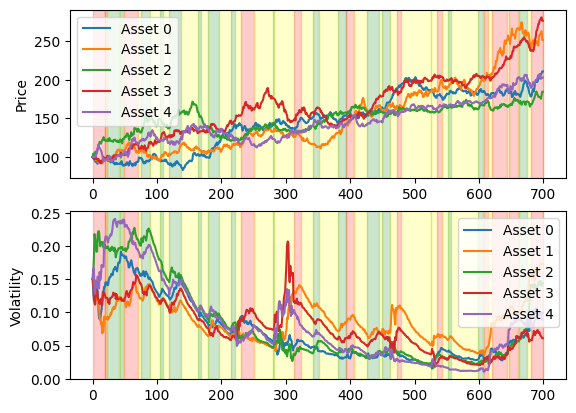

In [3]:

xi_values = [0.05, 0.2, 0.6] # volatility of volatility
kappa_values = [6, 1.0, 0.5] # mean reversion rate
theta_values = [0.01, 0.2, 1.2] # mean volatility
mu_values = [0.0, 1.0, -1.0] # price drift

V0 = np.full(N, 0.15)
S0 = np.full(N, 100)

price_data_total = np.empty((T + T_test, N))
volatility_data_total = np.empty((T + T_test, N))

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2)

x_breakpoints = []
x_breakpoints_labels = []

t = 0
while t < T + T_test:
    this_regime = true_regimes_total[t]
    tt = t + 1
    while tt < T + T_test:
        if true_regimes_total[tt] == this_regime:
            tt += 1
        else:
            break
    x_breakpoints.append(tt)
    x_breakpoints_labels.append(this_regime)
    volatility_data_total[t:tt, :] = np.array([
            generate_volatility(
                V0=V0[i],
                xi=xi_values[this_regime],
                theta=theta_values[this_regime],
                kappa=kappa_values[this_regime],
                N=tt - t,
                dt=1/365
            )
            for i in range(N)
        ]).T
    price_data_total[t:tt, :] = np.array([
        generate_prices(
            vola_values=volatility_data_total[t:tt, i],
            S0=S0[i],
            N=tt - t,
            mu=mu_values[this_regime],
            dt=1/365
    )
        for i in range(N)
    ]).T
    V0 = volatility_data_total[tt - 1, :]
    S0 = price_data_total[tt - 1, :]
    t = tt

x_breakpoints_labels.append(this_regime)
x_breakpoints.append(t)

price_data = price_data_total[:T]
price_data_eval = price_data_total[T:]
volatility_data = volatility_data_total[:T]
volatility_data_data_eval = volatility_data_total[T:]

for i in range(N):
    ax1.plot(range(T + T_test), price_data_total[:, i], label=f"Asset {i}")
    ax2.plot(range(T + T_test), volatility_data_total[:, i], label=f"Asset {i}")

ax1.legend()
ax2.legend()
ax1.set_ylabel("Price")
ax2.set_ylabel("Volatility")

colors = ["green", "yellow", "red"]
color_labels = ["low vol", "medium vol", "high vol"]

for i in range(len(x_breakpoints) - 1):
    ax1.axvspan(x_breakpoints[i],
                x_breakpoints[i + 1], color=colors[x_breakpoints_labels[i]],
                alpha=0.2)
    ax2.axvspan(x_breakpoints[i],
                x_breakpoints[i + 1], color=colors[x_breakpoints_labels[i]],
                alpha=0.2)

ax1.axvspan(0, x_breakpoints[0], color=colors[true_regimes[0]], alpha=0.2)
ax2.axvspan(0, x_breakpoints[0], color=colors[true_regimes[0]], alpha=0.2)

print(len(x_breakpoints_labels))

for c, cl in zip(colors, color_labels):
    print(f"color {c}: {cl}")

plt.show()

Compute returns and cumulative returns per asset

Regime 0: 209 samples
Regime 1: 217 samples
Regime 2: 74 samples


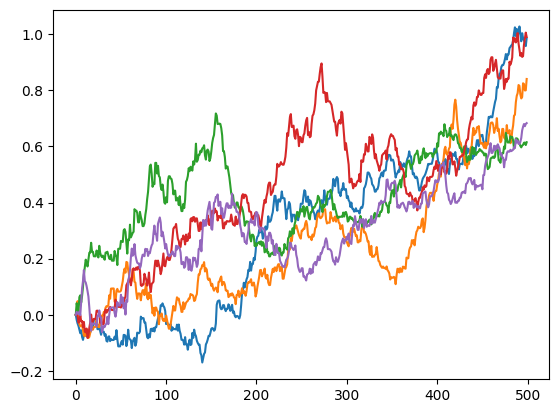

In [4]:

for m in range(M):
    print(f"Regime {m}: {np.sum(true_regimes == m)} samples")

returns_total = pd.DataFrame(price_data_total).pct_change(axis=0)
returns_total.iloc[0] = np.zeros(N)
cum_returns_total = (returns_total + 1).cumprod() - 1
cum_returns = cum_returns_total[:T]
cum_returns_eval = cum_returns_total[T:]
returns = returns_total[:T]
returns_eval = returns_total[T:]

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(range(T), cum_returns.values[:, i])

plt.show()

Plot the returns and volatility data per regime

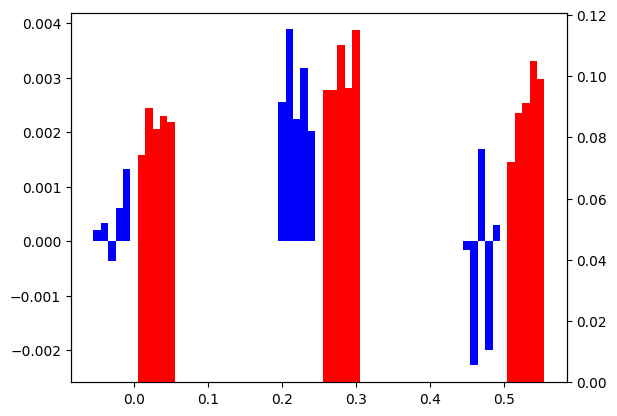

In [5]:
width = 1 / (2 * M * N) - 0.01
gap = 0.01
offsets = (np.arange(M) - (M - 1) / 2) * width

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for m in range(M):
    # shape (something, N)
    cur_returns = returns.values[true_regimes == m, :]
    cur_vola = volatility_data[true_regimes == m, :]

    c = m / (M + 1)
    xvalues1 = [c - i*gap for i in range(1, 1+N)]
    xvalues2 = [c + i*gap for i in range(1, 1+N)]

    ax1.bar(xvalues1, cur_returns.mean(axis=0), width=gap, color='blue')
    ax2.bar(xvalues2, cur_vola.mean(axis=0), width=gap, color='red')

plt.show()




Construct true values of $\mu$, $\Sigma$ and $B$ parameters of the model, using return value and the true regime sequence

In [6]:

mus_real = np.empty((M, N))
Sigma_real = np.empty((M, N, N))

a = np.empty((M, N))
for m in range(M):
    reg_returns_real = returns.values[true_regimes == m, :]
    #print('reg returns real:'); print(reg_returns_real)
    mus_real[m, :] = reg_returns_real.mean(axis=0)
    Sigma_real[m, :, :] = np.cov(reg_returns_real, rowvar=False)
    a[m, :] = [Sigma_real[m, n, n] for n in range(N)]

print('diag values for each regime:')
print(a)

mus_manual = np.empty((M, N))
Sigma_manual = np.empty((M, N, N))

for m in range(M):
    # Select returns that belong to regime m
    reg_returns = returns.values[true_regimes == m, :]
    mus_manual[m, :] = reg_returns.mean(axis=0)
    Sigma_manual[m, :, :] = np.cov(reg_returns, rowvar=False)
    print(f"Regime {m} variances:", np.diag(Sigma_manual[m]))


# true value of B
logb_real = compute_b(mus_real, Sigma_real, returns.values, T, M)
B_real = np.exp(logb_real)

diag values for each regime:
[[0.00020494 0.00021793 0.00016608 0.00019673 0.00021791]
 [0.00024785 0.00026223 0.00025256 0.00022204 0.00027556]
 [0.0001716  0.00021817 0.00022897 0.00024837 0.0003128 ]]
Regime 0 variances: [0.00020494 0.00021793 0.00016608 0.00019673 0.00021791]
Regime 1 variances: [0.00024785 0.00026223 0.00025256 0.00022204 0.00027556]
Regime 2 variances: [0.0001716  0.00021817 0.00022897 0.00024837 0.0003128 ]


Compute the estimated volatility from the returns array. Here we use spectral clustering instead of k-means on the volatility values, to obtain an estimated regime sequence. The aim is for the model to cluster the data in a non-linear way, hoping that it will learn more complex relationships between this data.

We use this sequence to construct a parameter estimation set $(\mu_i,\Sigma_i)$ for each regime $i$.

In [7]:

calc_volatility = returns.rolling(30, min_periods=0).std()
calc_volatility.iloc[0] = calc_volatility.iloc[1]
est_regimes = SpectralClustering(n_clusters=M, affinity='rbf').fit_predict(calc_volatility.values)

mus = np.empty((M, N))

# mus: shape M x N
# clusters: shape M x (num_vectors_in_cluster) x N
Sigma = np.empty((M, N, N))

a = np.empty((M, N))
for m in range(M):
    # find returns corresponding to regime m
    reg_returns = returns.values[est_regimes == m, :]
    
    mus[m, :] = reg_returns.mean(axis=0)
    Sigma[m, :, :] = np.cov(reg_returns, rowvar=False)
    a[m, :] = [Sigma[m, n, n] for n in range(N)]
print(a)
    

# construct the estimated version of A (using estimated regime sequence)
A = np.zeros((M, M))
pi = np.zeros(M)
for m in range(len(est_regimes[:-1])):
    cur_est_regime = est_regimes[m]
    next_est_regime = est_regimes[m + 1]
    A[cur_est_regime, next_est_regime] += 1
    pi[cur_est_regime] += 1
A_sum = A.sum(axis=1)
for n in range(M):
    A[n, :] /= A_sum[n]
pi /= pi.sum()

print(A)
print(); print(est_regimes)
print(); print(pi)


[[0.00015253 0.00019978 0.00012465 0.00018649 0.0001496 ]
 [0.00036348 0.00029106 0.0003184  0.00025477 0.00046634]
 [0.00026253 0.00035663 0.00048846 0.00033954 0.00040589]]
[[1.         0.         0.        ]
 [0.008      0.976      0.016     ]
 [0.         0.05357143 0.94642857]]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Run algorithm

In [8]:

pct_change_ll_tol = 1e-06
n_attempts = 100
max_attempt_per_iter = 10

# noise addition to initial parameter guesses
A_noise_std = 0.2
pi_noise_std = 0.2
Sigma_noise_std = 0.5

# these will store data from every run
# structure: list of lists (inner list = data per iteration)
ll_list = []

# these will store data from every run
# stucture: list of floats (one per attempt, not one per iteration)
pct_states_matched_viterbi = []
frac_correct_states_predicted_list = []
all_predicted_obs = []


tt = []

for attempt in range(n_attempts):

    prev_ll = 1.0
    log_ll = 2.0

    # initialize parameters

    # choose diagonal values of A randomly
    A_est = np.empty((M, M))
    for m in range(M):
        diagval = np.clip(A[m, m] + np.random.normal(0, A_noise_std), 0.01, 0.99)
        A_est[m, :] = (1 - diagval) / (M - 1)
        A_est[m, m] = diagval
    loga = np.log(A_est)

    mus_std = np.empty((M, N))
    mus_std_vals = mus.std(axis=1)
    for i in range(N):
        mus_std[:, i] = mus_std_vals

    k = np.random.normal(np.zeros((M, N)), mus_std, (M, N))
    mus_est = mus + k
    

    Sigma_est = Sigma.copy()
    for m in range(M):
        Sigma_est[m, :, :] = np.clip(Sigma[m, :, :] + Sigma_noise_std * np.eye(N), a_min=1e-5, a_max=10)

    print(f"Attempt {attempt} sigma est: {Sigma_est}")
    
    #print('COMPUTING LOGB USING MUS EST:'); print(mus_est); print('AND SIGMA EST:'); print(Sigma_est)
    logb = compute_b(mus_est, Sigma_est, returns.values, T, M)
    B_est = np.exp(logb)

    pi_est = pi + np.random.normal(0, pi_noise_std, M)
    pi_est /= pi_est.sum()
    pi_est = np.clip(pi_est, 1e-10, None)
    logpi = np.log(pi_est)

    # store some metrics for each iterion step
    this_attempt_ll_list = []

    this_attempt_count = 0

    print('first mu est:', mus_est)

    hard_iters = 4

    while abs(prev_ll - log_ll) / abs(prev_ll) > pct_change_ll_tol and this_attempt_count < max_attempt_per_iter:
        prev_ll = log_ll

        # E step
        logalpha, scaling = forward(loga, logb, T, M, logpi)
        logbeta = backward(loga, logb, T, M, scaling)
        logxi = compute_xi(logalpha, logbeta, loga, logb, T, M)

        if this_attempt_count < hard_iters:
            # Hard assignment enforcement
            gamma = np.zeros((T, M))
            for t in range(T):
                k = est_regimes[t]
                gamma[t, k] = 1.0

            loggamma = np.log(gamma + 1e-300)  # small number to prevent log(0)
        else:
            loggamma = compute_gamma(logalpha, logbeta, T, M)

        # M step
        loga = compute_a(loggamma, logxi, T, M)
        mus_est, Sigma_est = compute_mus_sigmas(loggamma, returns.values, T, M, N)
        print(f"Attempt {attempt} and iter count {this_attempt_count} sigma est: {Sigma_est}, having used loggamma: {loggamma}")

        logb = compute_b(mus_est, Sigma_est, returns.values, T, M)
        logpi = loggamma[0, :]

        # storing metrics for each iteration
        log_ll = np.sum(scaling)
        this_attempt_ll_list.append(log_ll)
        this_attempt_count += 1

    
    A = np.exp(loga)
    A /= A.sum(axis=1, keepdims=True)
    B = np.exp(logb)
    B /= B.sum(axis=1, keepdims=True)
    pi = np.exp(logpi)
    pi /= pi.sum()

    A = np.clip(A, 1e-10, 1)
    B = np.clip(B, 1e-10, 1)

    # store data from this attempt
    ll_list.append(this_attempt_ll_list)

    perm = match_states_by_gaussians(mus_est, Sigma_est, mus_real, Sigma_real)
    pi_p, A_p, mus_p, Sigma_p = permute_model(pi, A, mus_est, Sigma_est, perm)

    logpi_p = np.log(pi_p)
    loga_p = np.log(A_p)
    logb_p = compute_b(mus_p, Sigma_p, returns_eval.values, T_test, M)

    ##

    # assuming we have access to the future observations, we will test the model using the viterbi path
    # algorithm, to see how well it can predict the hidden state variables, given these observations
    predicted_states_vit, p = viterbi(logpi_p, logb_p, loga_p, T_test, M)
    pct_matched = 1 - np.count_nonzero(np.logical_xor(predicted_states_vit, true_regimes_eval)) / len(predicted_states_vit)
    pct_states_matched_viterbi.append(pct_matched)

    # assuming we are at time T and we wanted to predict the future states and observations up untill
    # t = T_test, we will try to predict these values and see how well the model generalizes
    predicted_obs = np.empty((T_test, N))
    predicted_states = np.empty(T_test, dtype=int)

    B_p = np.exp(logb_p)
    states_p_dist = np.exp(loggamma[-1, :])
    predicted_states[0] = np.argmax(states_p_dist)
    predicted_obs[0, :] = states_p_dist @ mus_p

    # generate prediction states and observations using A and B
    for k in range(1, T_test):
        """
        # prediction of states
        states_p_dist = states_p_dist @ A_p
        states_p_dist /= states_p_dist.sum()
        predicted_states[k] = np.argmax(states_p_dist)
        # determine the predicted observation by taking the most likely observation, given the
        # predicted state value
        predicted_obs[k, :] = states_p_dist @ mus_p
        """
        states_p_dist = states_p_dist @ A_p
        states_p_dist /= states_p_dist.sum()
        sampled_regime = np.random.choice(np.arange(M), p=states_p_dist)
        predicted_states[k] = sampled_regime
        predicted_obs[k, :] = np.random.multivariate_normal(mus_p[sampled_regime], Sigma_p[sampled_regime])

        #print('PREDICTED OBS:'); print(predicted_obs[k, :]); print('WITH STATES P DIST', states_p_dist, 'AND MUSP', mus_p)

    # save the fraction of correctly predicted states and observations
    frac_correct_states_predicted = 1 - np.count_nonzero(np.logical_xor(true_regimes_eval, predicted_states)) / len(predicted_states)
    all_predicted_obs.append(predicted_obs)
    frac_correct_states_predicted_list.append(frac_correct_states_predicted)

Attempt 0 sigma est: [[[5.00152526e-01 1.16247766e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05]
  [1.16247766e-05 5.00199779e-01 1.30028219e-05 1.00000000e-05
   1.00000000e-05]
  [1.00000000e-05 1.30028219e-05 5.00124649e-01 1.00000000e-05
   1.00000000e-05]
  [1.00000000e-05 1.00000000e-05 1.00000000e-05 5.00186488e-01
   1.00000000e-05]
  [1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
   5.00149596e-01]]

 [[5.00363478e-01 1.00000000e-05 2.21645431e-05 1.00000000e-05
   1.00000000e-05]
  [1.00000000e-05 5.00291063e-01 1.00000000e-05 1.33554334e-05
   1.00000000e-05]
  [2.21645431e-05 1.00000000e-05 5.00318399e-01 2.20619873e-05
   1.00472074e-05]
  [1.00000000e-05 1.33554334e-05 2.20619873e-05 5.00254769e-01
   1.00000000e-05]
  [1.00000000e-05 1.00000000e-05 1.00472074e-05 1.00000000e-05
   5.00466341e-01]]

 [[5.00262531e-01 3.30055923e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05]
  [3.30055923e-05 5.00356627e-01 1.00678074e-05 3.75968788e-05
   1.39692

Plot the log-likelyhood values of each attempt

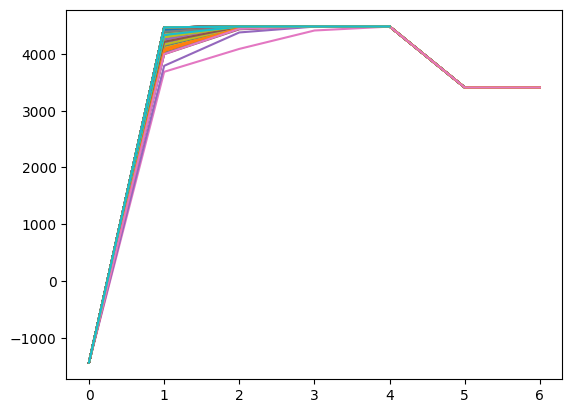

In [9]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(n_attempts):
    ax.plot(list(range(len(ll_list[i]))), ll_list[i])

plt.show()

Make a bar chart out of the fraction of correctly predicted states, given the true observations from $t=T_{\text{test}}$ onwards (from the Viterbi algorithm)

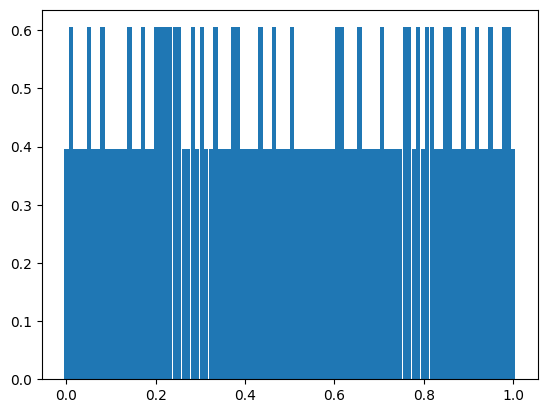

maximum pct correct: 0.605 from attempt 2
minimum pct correct: 0.395 from attempt 1


In [10]:
plt.bar(np.linspace(0, 1, n_attempts), pct_states_matched_viterbi, width=1/(1 + n_attempts))
plt.show()

print('maximum pct correct:', np.max(pct_states_matched_viterbi), 'from attempt', np.argmax(pct_states_matched_viterbi) + 1)
print('minimum pct correct:', np.min(pct_states_matched_viterbi), 'from attempt', np.argmin(pct_states_matched_viterbi) + 1)

Plot the fraction of correctly predicted states, from only the model's estimation parameters

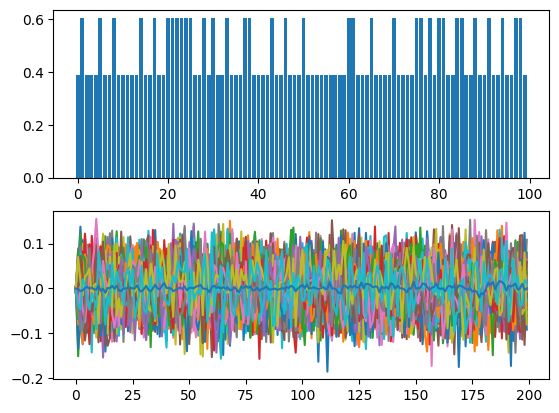

In [11]:

fig, (ax1, ax2) = plt.subplots(2)
ax1.bar(range(len(frac_correct_states_predicted_list)), frac_correct_states_predicted_list, label="Pct correctly predicted states")

# print(returns_eval.mean(axis=1))
for n in range(len(all_predicted_obs)):
    ax2.plot(all_predicted_obs[n].mean(axis=1))
ax2.plot(returns_eval.values.mean(axis=1))

plt.show()


Plot the estimated vs. the real volatility values (for each attempt)

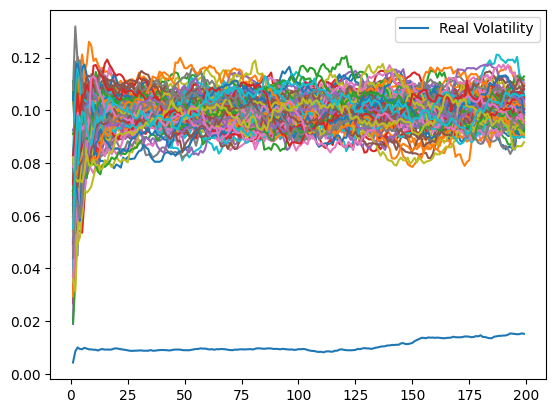

In [12]:
window = 30 # or any window size relevant for your domain
real_vol = pd.DataFrame(returns_eval.values).rolling(window, min_periods=1).std().mean(axis=1)
for n in range(n_attempts):
    model_vol = pd.DataFrame(all_predicted_obs[n]).rolling(window, min_periods=1).std().mean(axis=1)
    plt.plot(model_vol)

plt.plot(real_vol, label="Real Volatility")
plt.legend()
plt.show()
